# Lab 5 - Diffusion

In [17]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import time

### Some preliminary data observations

In [2]:
bicycle = []

with open("bicycle.txt") as file:
    lines = file.readlines()
    bicycle = [(float(line.split()[0]), float(line.split()[1])) for line in lines]

bicycle = torch.Tensor(bicycle)
bicycle

tensor([[ 0.2370,  1.0000],
        [ 0.2399,  1.0000],
        [ 0.2428,  1.0000],
        ...,
        [ 0.6705, -0.9954],
        [ 0.6734, -0.9954],
        [ 0.6358, -1.0000]])

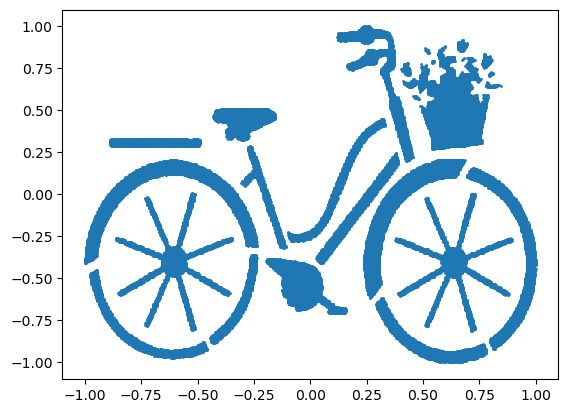

In [3]:
plt.scatter(bicycle[:, 0], bicycle[:, 1], s=1)

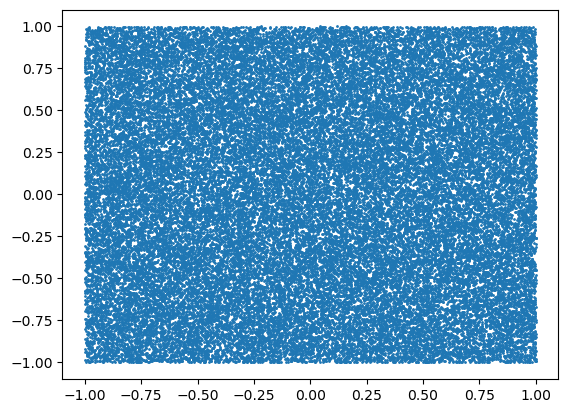

In [4]:
random_pointcloud = torch.rand(bicycle.shape) * 2 - 1
plt.scatter(random_pointcloud[:, 0], random_pointcloud[:, 1], s=1)

### Forward diffusion

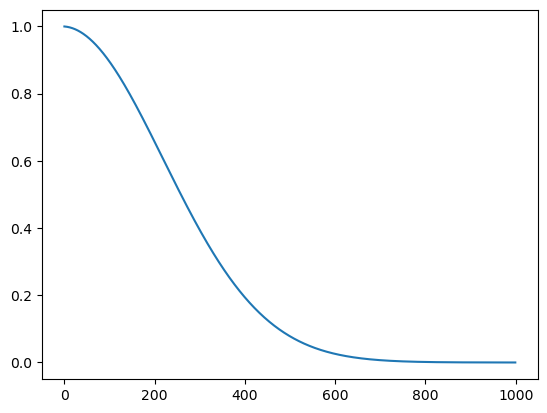

In [5]:
STEPS = 1000
beta = torch.linspace(0.0001, 0.02, STEPS)
alfa = 1 - beta
alfa_product = torch.clone(alfa)
for i in range(1, len(alfa_product)):
    alfa_product[i] = alfa_product[i - 1] * alfa_product[i]

plt.plot(torch.arange(0, STEPS), alfa_product)

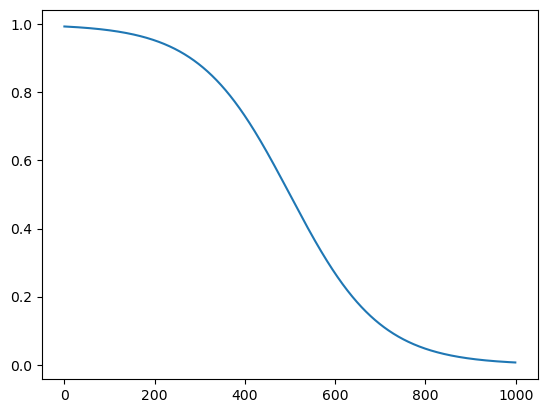

In [6]:
alfa_product = torch.sigmoid(torch.linspace(5, -5, 1000))
plt.plot(torch.arange(0, STEPS), alfa_product)

In [7]:
for i in range(1, len(alfa_product)):
    alfa[i] = alfa_product[i] / alfa_product[i - 1]

beta = 1 - alfa

In [88]:
def diffusion(batch: torch.Tensor, alfa_product: torch.Tensor, t: torch.Tensor, noise: torch.Tensor=None) -> torch.Tensor:
    mean = torch.sqrt(alfa_product[t]).unsqueeze(1) * batch
    if noise==None:
        std = torch.sqrt(1 - alfa_product[t]).unsqueeze(1) * torch.ones(batch.shape)

        samples = torch.normal(mean, std)

        return samples
    else:
        std = torch.sqrt(1 - alfa_product[t]).unsqueeze(1) * noise

        return mean + std


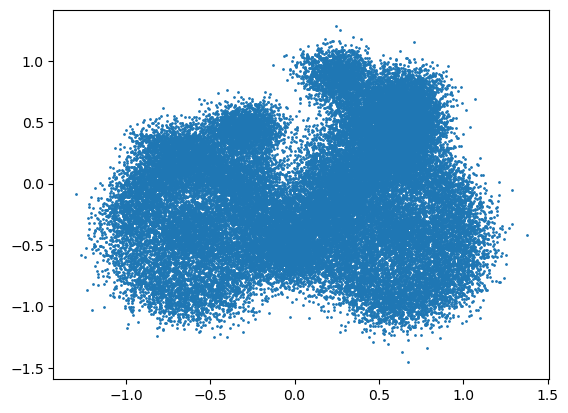

In [89]:
diffused_bicycle = diffusion(bicycle, alfa_product, torch.linspace(0, 80, len(bicycle), dtype=torch.int))
plt.scatter(diffused_bicycle[:, 0], diffused_bicycle[:, 1], s=1)

Diffusion works, we can melt the bicycle!

### DDPM - Denoising Diffusion Probabilistic Model

In [10]:
# https://github.com/wzlxjtu/PositionalEncoding2D/blob/master/positionalembedding2d.py
def positionalencoding1d(d_model, length):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError(
            "Cannot use sin/cos positional encoding with "
            "odd dim (got dim={:d})".format(d_model)
        )
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp(
        (
            torch.arange(0, d_model, 2, dtype=torch.float)
            * -(math.log(10000.0) / d_model)
        )
    )
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe

In [15]:
class DDPM(nn.Module):
    def __init__(self):
        super(DDPM, self).__init__()
        self.no_of_layers = 4
        self.d_model = 128
        self.encoding_length = 50
        self.input_size = 2

        self.encoding = positionalencoding1d(self.encoding_length, 1000)

        self.layers = nn.ModuleList(
            [nn.Sequential(nn.Linear(self.input_size, self.d_model), nn.ReLU())]
            + [
                nn.Sequential(nn.Linear(self.d_model, self.d_model), nn.ReLU())
                for _ in range(self.no_of_layers - 2)
            ]
            + [nn.Linear(self.d_model, self.input_size)]
        )

        self.learnable_sinusoidal_embeddings = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(self.encoding_length, self.d_model),
                    nn.ReLU(),
                    nn.Linear(self.d_model, self.d_model),
                )
                for _ in range(self.no_of_layers - 1)
            ]
            + [
                nn.Sequential(
                    nn.Linear(self.encoding_length, self.d_model),
                    nn.ReLU(),
                    nn.Linear(self.d_model, self.input_size),
                )
            ]
        )

    def forward(self, x, t):
        output = x
        for i in range(self.no_of_layers):
            output = self.layers[i](output) + self.learnable_sinusoidal_embeddings[i](
                self.encoding[t]
            )
            if i < self.no_of_layers - 1:
                output = nn.ReLU()(output)

        return output


model = DDPM()

BATCH_SIZE = 128

input = torch.rand([BATCH_SIZE, bicycle.shape[1]]) * 2 - 1
input.shape

model(input, 20).shape

torch.Size([128, 2])

### Training loop

In [128]:
EPOCH = 2000
MAX_T = 1000
BATCH_SIZE = 128
LR = 0.00001

model = DDPM()
optimizer = optim.Adam(model.parameters(), lr=LR)

criterion = nn.MSELoss()
start_time = time.time()

for epoch in range(EPOCH):
    indices = torch.randperm(len(bicycle))[:BATCH_SIZE]
    input = bicycle[indices]

    t = torch.randint(0, MAX_T, (BATCH_SIZE, ))

    noise = torch.randn((BATCH_SIZE, 2))

    # Training Generator
    optimizer.zero_grad()
    predicted_noise = model(diffusion(input, alfa_product, t, noise=noise), t)

    loss = criterion(noise, predicted_noise)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(
        f"epoch: {epoch:04d}, time: {(time.time() - start_time)/60:1f}min, loss: {loss:.4f}"
        )
        print("Saving!")
        torch.save(model.state_dict(), f"lab5_checkpoints/model_{epoch}")
        torch.save(
            {
                "epoch": epoch,
                "loss": loss,
                "optimizer": optimizer.state_dict(),
            },
            f"lab5_checkpoints/optimizer_{epoch}",
        )

epoch: 0000, time: 0.000152min, loss: 0.9101
Saving!
epoch: 0050, time: 0.007807min, loss: 1.0044
Saving!
epoch: 0100, time: 0.012646min, loss: 0.9092
Saving!
epoch: 0150, time: 0.019254min, loss: 0.9305
Saving!
epoch: 0200, time: 0.024933min, loss: 0.8316
Saving!
epoch: 0250, time: 0.029807min, loss: 0.9924
Saving!
epoch: 0300, time: 0.035198min, loss: 0.8476
Saving!
epoch: 0350, time: 0.041575min, loss: 0.7623
Saving!
epoch: 0400, time: 0.047014min, loss: 0.7578
Saving!
epoch: 0450, time: 0.052196min, loss: 0.7640
Saving!
epoch: 0500, time: 0.056807min, loss: 0.7261
Saving!
epoch: 0550, time: 0.061220min, loss: 0.6903
Saving!
epoch: 0600, time: 0.065383min, loss: 0.7014
Saving!
epoch: 0650, time: 0.069915min, loss: 0.7510
Saving!
epoch: 0700, time: 0.074740min, loss: 0.4620
Saving!
epoch: 0750, time: 0.080760min, loss: 0.6526
Saving!
epoch: 0800, time: 0.086061min, loss: 0.4591
Saving!
epoch: 0850, time: 0.091118min, loss: 0.5299
Saving!
epoch: 0900, time: 0.095456min, loss: 0.5456
S

In [129]:
@torch.no_grad()
def sample(alfa_product, alfa, bs=5):
    x = [None] * MAX_T
    x[MAX_T - 1] =  torch.randn((bs, 2))

    for t in range(MAX_T - 1, 0 , -1):
        z = 0
        if t > 1:
            z = torch.randn((bs, 2))

        x[t - 1] = 1 / torch.sqrt(alfa[t]) * (x[t] - (1 - alfa[t]) / torch.sqrt(1 - alfa_product[t]) * model(x[t], t)) + torch.sqrt(1 - alfa[t]) * z

    return x


points = sample(alfa_product, alfa, 1000)

torch.Size([1000, 2])


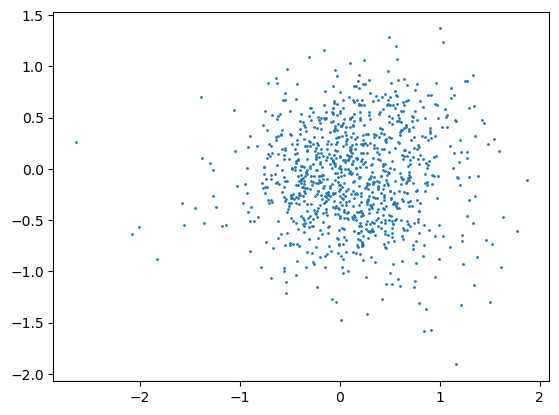

In [130]:

print(points[0].shape)
plt.scatter(points[100][:, 0], points[0][:, 1], s=1)